**참고문헌: 핸즈온 머신러닝(2판), 올레리앙 제롱 지음, 박해선 옮김, 3장 – 분류** 

강의계획
- MNIST 데이터를 활용한 분류
- 이진 분류기(binary classifier) 훈련
- 성능 측정
  - 과소적합과 과적합
- Validation Datset
  - Validation Dataset과 Test Dataset의 용도
  - 교차 검증(Cross-validation)을 사용한 정확도 측정
  - K-폴드 교차 검증(K-fold cross validation)
  - 예제를 통한 교차검증 구현
- 혼동 행렬(confusion matrix)
  - 정확도, 정밀도, 민감도, f1 score 계산하기 
  - 정밀도와 재현율
  - 정밀도/재현율 트레이드오프
  - ROC 곡선
- 다중 분류(SVM을 사용한 예제)
  - 에러 분석
- 다중 레이블 분류(K-Neighbors Classifier를 사용한 예제)
- 다중 출력 분류(K-Neighbors Classifier를 사용한 예제)
- 연습문제
  - MNIST 분류기, 데이터 증식(data augmentation)

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# MNIST (Modified National Institute of Standards and Technology database) 데이터를 활용한 분류(Classification)


<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/MnistExamples.png">

MNIST 데이터베이스 는 손으로 쓴 숫자들로 이루어진 대형 데이터베이스이며, 다양한 화상 처리 시스템을 트레이닝하기 위해 일반적으로 사용됩니다. 이 데이터베이스는 또한 기계 학습 분야의 트레이닝 및 테스트에 널리 사용됩니다. MIST의 흑백 그림들은 28x28 픽셀의 그레이스케일 레벨되어 있는 데이터입니다. 

MNIST sample images.
MNIST 데이터베이스는 60,000개의 트레이닝 이미지와 10,000개의 테스트 이미지를 포함합니다.


In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

In [ ]:
28 * 28

784

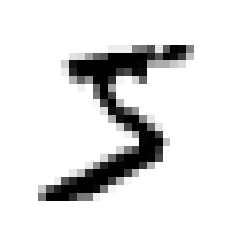

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

# save_fig("some_digit_plot")
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
y = y.astype(np.uint8)

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

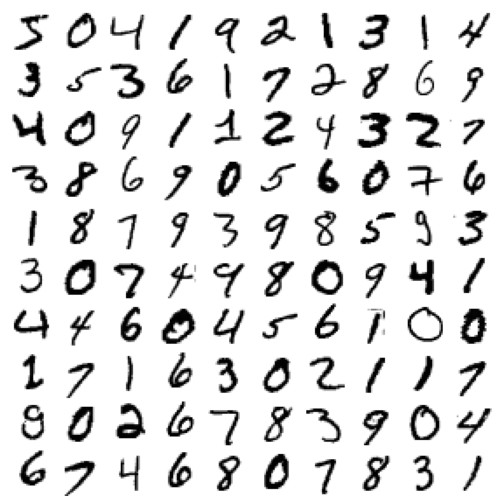

In [ ]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
# save_fig("more_digits_plot")
plt.show()

In [ ]:
y[0]

5

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기 (binary classifier) 훈련 

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**노트**: `max_iter`와 `tol` 같은 일부 매개변수는 사이킷런 다음 버전에서 기본값이 바뀝니다. 버전이 업데이트되더라도 결과가 바뀌지 않도록 아예 나중에 바뀔 기본값을 사용해 명시적으로 지정하겠습니다. 번거로움을 피하기 위해 책에는 따로 표시하지 않았습니다.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
# 확률적 경사하강법(SGD, Stochastic Gradient Descent)을 이용하여 선형모델을 구현
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

# 성능 측정

참고문헌: https://untitledtblog.tistory.com/158

### 과소적합 (underfitting)과 과적합 (overfitting)
머신 러닝의 궁극적인 목표는 training dataset을 이용하여 학습한 모델을 가지고 test dataset를 예측하는 것이다. 이 때 test dataset은 학습 과정에서 참조할 수 없다고 가정하기 때문에 머신 러닝 모델은 training dataset만을 가지고 test dataset을 잘 예측하도록 학습되어야 한다.

<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_1.png"/>
<figcaption>그림1. 학습의 진행과 decision boundary의 형태 변화. 각 점은 training dataset에 포함된 data를 의미하며, 점의 색은 class를 의미함.</figcaption>
</figure>


기본적으로 머신 러닝 모델은 training loss가 작아지도록 학습을 진행하기 때문에 그림 1과 같이 학습이 계속 될수록 모델의 decision boundary는 점점 training dataset에 fitting된다. 이러한 학습 결과는 모델이 dataset에 내재된 어떠한 구조나 패턴을 일반화 (generalization)한 것이 아니라, training dataset을 그대로 외운 것과 같이 때문에 이것이 올바른 학습 결과인지는 생각해볼 필요가 있다.



만약 training dataset과 test dataset이 정확히 일치한다면, training dataset에 fitting될 수록 모델의 예측 정확도는 증가할 것이다. 그러나 대부분의 문제에서 training dataset과 test dataset은 조금씩 다른 경향을 보인다 (실제 application에서는 매우 다른 경우도 많다). 이러한 경우에는 그림 2와 같이 training dataset에 조금은 덜 fitting된 모델이 test dataset에 대해 더 높은 정확도를 보일 수가 있다.


<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_2.png"/>
<figcaption>그림 2. Training dataset에 덜 fitting된 모델 (좌)과 과하게 fitting된 모델 (우). 각 점은 test dataset에 포함된 data를 의미함.</figcaption>
</figure>

실제로 그림 2처럼 training dataset에 과하게 fitting된 모델이 test dataset에 대해 더 낮은 정확도를 보여주는 문제는 거의 대부분의 머신 러닝 응용에서 나타난다.


<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_3.png"/ height="300" width="380">
<figcaption>그림 3. Loss의 관점에서 보는 underfitting과 overfitting.</figcaption>
</figure>

그림 3은 loss의 관점에서 위의 예제를 보여준다. 위의 그래프는 아래와 같은 두 개의 구간으로 나눌 수 있다.

* Training loss와 test loss가 같이 감소하는 구간 (underfitting).
* Training loss는 감소하지만, test loss는 증가하는 구간 (overfitting).

머신 러닝에서는 전자의 구간에 있는 모델을 underfitting되었다고 하고, 후자에 있는 모델은 overfitting되었다고 한다. 따라서, 우리의 목적은 학습을 통해 머신 러닝 모델의 underfitting된 부분을 제거해나가면서 overfitting이 발생하기 직전에 학습을 멈추는 것이다. 이를 위해 머신 러닝에서는 validation set을 이용한다.



# Validation Dataset
Validation dataset은 overfitting을 해결하기 위해 별도로 만들어진 dataset이 아니라, training dataset에서 추출된 가상의 dataset이다.

<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_4.png"/>
<figcaption>그림 4. Validation dataset을 이용한 학습 과정.</figcaption>
</figure>

그림 4는 이러한 validation dataset을 이용한 머신 러닝 모델의 학습 과정을 보여준다.

* Step (1): 주어진 dataset을 training, validation, test dataset들로 나눈다. 일반적으로 각 dataset의 비율은 60:20:20으로 설정한다.
* Step (2): Training dataset을 이용하여 모델을 학습시킨다.
* Step (3): Validation dataset을 이용하여 모델의 정확도 및 validation dataset에 대한 loss를 계산한다.
* Step (4): 만약 validation loss가 증가했다면 학습을 종료한다. 그렇지 않을 경우에는 (2)로 돌아가서 학습을 계속 진행한다.
* Step (5): Test dataset을 이용하여 모델의 최종 정확도를 평가한다.

그림 4의 학습 과정과 기존 training dataset 및 test dataset만을 이용한 학습의 가장 큰 차이점은 step (3)과 (4)가 추가되었다는 점이다. 이러한 두 과정을 통해 현재의 모델이 학습 과정에서 참조하지 않았던 data를 얼마나 정확하게 예측하는지를 평가하고, 이를 학습의 종료 조건으로 이용함으로써 overfitting을 간접적으로 방지한다.


<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_5.png"/ height="300" width="500">
<figcaption>그림 5. Validation loss를 이용한 overfitting 방지.</figcaption>
</figure>


그림 5는 validation loss를 이용하여 overfitting을 방지하는 방법을 보여준다. 위의 그래프에서 볼 수 있듯이 validation loss가 증가하는 시점부터 overfitting이 발생했다고 판단하고, 이에 따라 학습을 중단한다. 그러나 validation dataset 또한 test dataset을 완벽히 표현하지는 못 하기 때문에 validation loss가 최소가 되는 시점이 test loss가 최소가 되는 시점과 정확히 일치하지는 않을 수도 있다.

 



## Validation Dataset과 Test Dataset의 용도

처음 머신 러닝을 접하면 validation dataset의 개념을 정확히 이해하지 못 하거나, validation과 test dataset들의 개념을 혼동할 수도 있다. 아래의 표 1은 혼동하기 쉬운 training, validation, test dataset들의 용도를 요약한 것이다.

<figure>
<figcaption>1. Traning, validation, test dataset들의 용도.
</figcaption>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_T1.png"/>
</figure>

Validation dataset과 test dataset의 개념 중 혼동하기 쉬운 몇 가지를 요약하면 아래와 같다.

* Validation dataset은 학습 과정에서 참조할 수 있지만, test dataset은 그렇지 않다.
* Training dataset은 모델의 인자값 (인공신경망에서는 가중치)을 결정하는데 이용되지만, validation dataset은 이용되지 않는다. 
* Validation dataset은 오직 언제 학습을 멈출지를 판단하기 위해 이용된다. Validation dataset과 test dataset은 모두 모델의 성능 평가에 이용된다. 그러나 validation dataset에 대한 성능은 학습을 중단하는 시점을 결정하기 위해 이용되고, test dataset에 대한 성능은 모델의 최종 정확도를 평가하기 위해 이용된다.



## 교차 검증(cross-validation)을 사용한 정확도 측정

참고문헌 :https://kimdingko-world.tistory.com/167


교차 검증이란 쉽게 생각하면 본고사를 치르기 전 모의고사를 여러 번 보는 것입니다.

본고사는 테스트 데이터 세트에 대한 마지막 평가로 이해할 수 있고 모의고사는 교차 검증에서 많은 학습과 검증 세트에서 알고리즘 학습과 평가를 수행하는 것입니다.

 
기계학습(딥러닝)은 데이터를 기반해서 학습됩니다. 그리고 그 데이터는 기계학습(딥러닝)에 미치는 다양한 요소를 가지고 있습니다.

따라서 특정 ML 알고리즘에서만 최적의 성능을 보이도록 데이터를 선별해 학습한다면 결국 실제 데이터 양식과 큰 차이가 있을 것이고 이는 성능 저하로 이어집니다.

 
정리하면 교차검증은 데이터 편중을 막기 위해 별도의 여러 세트로 구성된 학습 데이터 세트와 검증 데이터 세트에서 학습과 평가를 수행하는 것입니다.

 
그리고 각 세트에서 수행한 결과에 따라 하이퍼 파라미터 튜닝 등의 모델 최적화를 더욱 손쉽게 할 수 있습니다.

 
대부분의 기계학습(딥러닝) 모델 성능 평가는 교차 검증 기반 1차 평가 후 최종 테스트 데이터 세트에 적용해 평가하는 프로세스를 가집니다.

기계학습(딥러닝) 사용되는 데이터 세트를 세분화하면 다음과 같습니다.

1. 학습

2. 검증

3. 테스트




<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_6.png"/>
<figcaption>그림 6. 학습, 검증, 테스트 세트 예시 </figcaption>
</figure>

## K 폴드 교차 검증 (K-fold cross-validation)
 
K 폴드 교차검증은 가장 보편적으로 사용되는 교차 검증 기법입니다.

먼저 K개의 데이터 폴드 세트를 만들어서 K번만큼 각 폴드 세트에 학습과 검증을 반복적으로 수행해는 방법입니다.

아래의 그림은 5 폴드 교차 검증을 수행합니다.(K=5)

5개의 폴드된 데이터 세트를 학습과 검증을 위한 데이터 세트로 변경하면서 5번 평가를 수행한 뒤, 이 5개의 평가를 평균한 결과를 가지고 예측 성능을 평가합니다.

<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_7.png"/>
<figcaption> 그림 7. CV 예시 </figcaption>
</figure>

먼저 데이터 세트를 K등분(5)합니다. 그리고 Experiment 1에서는 2번부터 5번까지의 등분을 학습 데이터 세트, 1번 등분을 검증 데이터 세트로 설정하고 학습 데이터에서 학습, 검증 데이터에서 평가를 수행합니다.

Experiment1이 끝나면 Experiment2로 넘어가 같은 작업을 반복합니다.

 
이렇게 각 Experiment(학습/검증)에 대해 학습 데이터 세트와 검증 데이터 세트를 점진적을 변경하면서 마지막 K번째 까지 학습과 검증을 수행하는 것이 K 폴드 교차 검증입니다.

이렇게 구해진 5개의 예측 평가를 구하면 이 값을 평균해서 K 폴드 평가 결과로 반영합니다.



## 예제를 통한 교차검증 구현

stratifiedKFold: https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

노트: 이 출력(그리고 이 노트북과 다른 노트북의 출력)이 책의 내용과 조금 다를 수 있습니다. 걱정할 필요 없습니다. 괜찮습니다! 달라지는 이유가 몇가지 있습니다:

* 첫째, 사이킷런과 다른 라이브러리들이 발전하면서 알고리즘이 조금씩 변경되기 때문에 얻어지는 결괏값이 바뀔 수 있습니다. 최신 사이킷런 버전을 사용한다면(일반적으로 권장됩니다) 책이나 이 노트북을 만들 때 사용한 버전과 다를 것이므로 차이가 납니다. 노트북은 최신으로 업데이트하려고 노력하지만 책의 내용은 그렇게 할 수 없습니다.
* 둘째, 많은 훈련 알고리즘은 확률적입니다. 즉 무작위성에 의존합니다. 이론적으로 의사 난수를 생성하도록 난순 생성기에 시드 값을 지정하여 일관된 결과를 얻을 수 있습니다(random_state=42나 np.random.seed(42)를 종종 보게 되는 이유입니다). 하지만 여기에서 언급한 다른 요인으로 인해 충분하지 않을 때가 있습니다.
* 세째, 훈련 알고리즘이 여러 스레드(C로 구현된 알고리즘)나 여러 프로세스(예를 들어 n_jobs 매개변수를 사용할 때)로 실행되면 연산이 실행되는 정확한 순서가 항상 보장되지 않습니다. 따라서 결괏값이 조금 다를 수 있습니다.
* 마지막으로, 여러 세션에 결쳐 순서가 보장되지 않는 파이썬 딕셔너리(dict)이나 셋(set) 같은 것은 완벽한 재현성이 불가능합니다. 또한 디렉토리 안에 있는 파일의 순서도 보장되지 않습니다.

# 혼동 행렬 (confusion matrix)
추가 교재 참고: MOBI224_wk05-1_성능지표.pdf

참고문헌: https://lovelydiary.tistory.com/363

혼동행렬은 분류 모델의 성능을 평가하는 지표로서 영어로는 confusion matrix라고 하며 혼돈행렬, 정오행렬, 오분류표 등으로도 불린다. 지도학습을 통해 모델링한 "분류 모델이 예측한 값"과 레이블되어 있는 "원래의 값" 간의 관계를 표로 나타낸다. 이 표를 통해 해당 모델의 정확도(accuracy), 정밀도(precision), 민감도(sensitivity), f1 score 등을 파악할 수 있으며, 이 중에서도 특히 정확도를 통해 해당 모델이 정확하게 분류해 낼 수 있는 비율을 지 확인할 수 있다.



||실제값(P-실제로 맞다) | 실제값(N-실제로 틀리다)|
|---|---|---|
|모델의 예측값 (P로 예측-맞다고 예측)|True Positive(TP)|False Positive (FP)|
|모델의 예측값 (N로 예측-틀리다고 예측)|False Negative (FN)| True Negative(TN)|



일반적으로 혼동행렬은 위와 같이 행에 모델의 예측값의 두 경우(Positive, Negative)를 놓고, 열에 실제 값의 두 경우(Positive, Negative)를 놓는데, 예측값과 실제값의 위치를 바꾸어 놓는 경우도 있다. 이런 경우, TP, FP, FN, TN의 자리가 변경되어서 각종 지표들을 계산하는 것이 헷갈릴 수 있으므로 자리를 기억하기보다는 예측값과 실제값의 조합에 따른 Case를 잘 이해해두는 것이 좋다. 혼동행렬은 총 4개의 경우의 수, 셀값을 가지는데 이는 "두개의 알파벳"으로 기억하면 된다. 첫번째 알파벳은 예측값과 실제값과 동일한지 여부를 나타내고 동일한 경우는 T(True), 상이하면 F(False)로 적는다. 두번째 알파벳은 모델이 예측한 값을 나타내는데 모델의 예측값이 P(Positive)이면 P, 모델이 예측을 N(Negative)로 했으면 N이 된다.



In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5  # 완변한척 하자
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 혼동행렬로부터 정확도, 정밀도, 민감도, f1 score 계산하기

혼동행렬의 셀값을 활용해서 해당 모델을 평가하기 위한 여러 지표들을 아래와 같이 계산할 수 있다. 

 1) 정확도(accuracy): (TP+TN) / (TP+TN+FP+FN)

 2) 정밀도(precision): TP / (TP+ FP)

 3) 민감도(sensitivity = 재현율 recall): TP / (TP+FN)

 4) f1 score: 2 * 정밀도* 민감도 / (정밀도+민감도)

## 정밀도와 재현율

정밀도
* 모델의 예측값이 얼마나 정확하게 예측됐는가를 나타내는 지표
* "예"라고 예측했을때의 정답률

재현율
* 실제값 중에서 모델이 검출한 실제값의 비율을 나타내는 지표
* 실제로 병이 있는 전체 중 참 긍정의 비율
* 실제 암환자들이 병원에 갔을때 암환자라고 예측될 확률,
* 조기에 정확하게 발견해서 신속하게 처방하는 것이 올바른 모델


In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
cm = confusion_matrix(y_train_5, y_train_pred)

cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## 정밀도/재현율 트레이드오프

정밀도
* 정밀도 중요하고 재현율도 중요한데 둘 중 무엇을 쓸지 고민될 수 있다.
* 이 두값 조화평균내서 하나의 수치로 나타낸 지표


In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

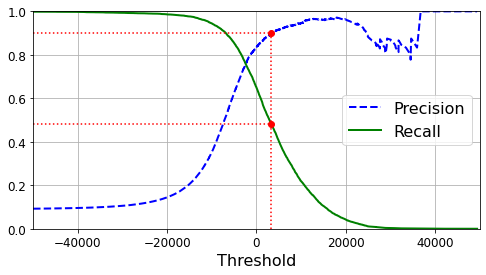

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
# save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [ ]:
(y_train_pred == (y_scores > 0)).all()

True

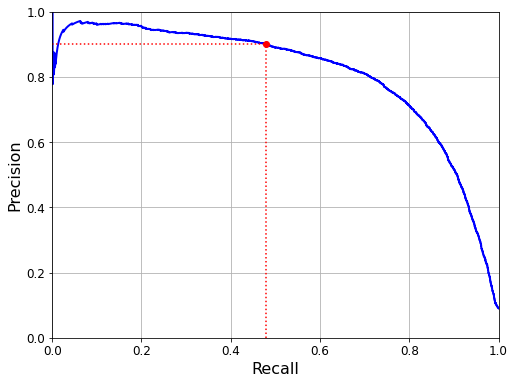

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [ ]:
threshold_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC 곡선
참고문헌: https://angeloyeo.github.io/2020/08/05/ROC.html

ROC(Receiver Operating Characteristic) curve는 다양한 threshold에 대한 이진분류기의 성능을 한번에 표시한 것이다. 이진 분류의 성능은 True Positive Rate와 False Positive Rate 두 가지를 이용해서 표현하게 된다. ROC curve를 한 마디로 이야기하자면 ROC 커브는 좌상단에 붙어있는 커브가 더 좋은 분류기를 의미한다고 생각할 수 있다.

<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_8.png"/, width = 450, higeht = 450>
<figcaption>그림 8. ROC 커브가 좌상단에 붙어있을 수록 좋은 이진 분류기 </figcaption>
</figure>





ROC curve를 잘 이해하기 위해선 ROC curve plot에서 보이는 세 가지 특성에 대해 파악하는 것이 좋다.

* True Positive Rate과 False Positive Rate
* ROC Curve위의 한 점이 의미하는 것은 무엇인가?
* ROC Curve의 휜 정도가 의미하는 것은 무엇인가?

<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_9.png"/>
<figcaption>그림 9. ROC curve를 이해하기 위해 알아야할 것들 </figcaption>
</figure>


### True Positive? False Positive?

False Positive Rate(FPR)와 True Positive Rate(TPR)은 ROC curve에서 각각 x, y축에 표시되는 값을 의미한다. 여기서 우리는 FPR과 TPR 모두 Positive라는 공통적인 단어가 있음을 발견할 수 있다. 

“Positive”의 의미는 판단자가 “그렇다”라고 판별했다는 의미이다.

가령 병원에 환자가 암 검사를 받기 위해 내원했고, 의사(즉, 여기서 판단자)가 “환자가 암에 걸렸다”라고 판단한 것이다. 그렇다면 True와 False는 무슨 의미일까?

True와 False는 각각 ‘판단을 올바르게 했다’는 것과 ‘판단을 틀리게 했다’는 것을 표현한다.

즉, 다시 말해 True Positive는 실제로 이 사람은 암에 걸려있고, 판단을 암에 걸렸다고 판단한 것이며, False Positive는 실제로는 암에 걸리지 않았는데도 암에 걸렸다고 ‘잘못’ 판단한 것을 의미한다.

그림으로 True Positive와 False Positive를 확인해보면 다음과 같이 생각할 수 있다.



<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_10.png">
<figcaption>그림 10. True Positive와 False Positive를 그림으로 나타낸 것. </figcaption>
</figure>



### TPR과 FPR의 관계

이제 의사(즉, 이진 분류기의 역할)의 성격과 실력에 대해 집중해보자. 의사 A는 겁이 없고 성격이 급해서 모든 환자들을 다 암환자라고 판단한다고 하자.

그러면 어떻게 될까? 실제로 암이 걸린 환자들도 모두 암 환자로 판정되면서 (즉, True Positive Rate은 높아지고) 동시에 암이 걸리지 않았던 내원 환자들도 모두 암 환자로 판정된다. (즉, False Positive Rate도 동시에 높아지게 된다) 그 내용을 그림으로 표현하면 아래와 같다. 모든 내원자들을 다 환자로 판정한다는 것은 threshold가 낮다는 뜻이다.




<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_11.gif">
<figcaption>그림 11. 겁 없는 의사 A 처럼 threshold를 매우 낮게 설정하는 경우의 True Positive와 False Positive 비율 변화 </figcaption>
</figure>





한편, 의사 B는 겁이 많아서 모든 환자들이 암환자가 아니라고 판단한다고 하자. 다시 말해 의사 B는 암이 걸리지 않은 내원자들 뿐만 아니라 실제로는 암에 걸린 내원자들도 모두 정상인으로 판정하면서 True Positive Rate과 False Positive Rate 모두 낮아지게 된다.

그 내용을 그림으로 표현하자면 아래와 같다. 모든 내원자들을 다 정상인으로 판정한다는 것은 threshold가 높다는 뜻이다.


<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_12.gif">
<figcaption>그림 12. 겁쟁이 의사 B 처럼 threshold를 높게 설정하는 경우의 True Positive와 False Positive 비율 변화
</figcaption>
</figure>





### 현 위의 점의 의미는 무엇인가?

위의 논의를 따라오다보면 threshold가 변함에 따라서 False Positive Rate(FPR)과 True Positive Rate(TPR)의 값이 바뀐다는 것을 알 수 있다. 또 한가지 추가로 알 수 있는 것은 threshold가 높아지건 낮아지건 FPR과 TPR은 어느정도는 비례적으로 함께 커지거나 작아진다는 것 또한 알 수 있다.

현 위의 점이 의미하는 것은 모든 가능한 threshold별 FPR과 TPR을 알아보겠다는 의미를 담고 있다. 즉, 현재 이진 분류기의 분류성능은 변하지 않되, 가능한 모든 threshold별 FPR과 TPR의 비율을 알아내서 plot하겠다는 의미를 담고 있다.


<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_13.gif">
<figcaption>그림 13. threshold 변화에 따른 ROC 커브 위의 점 위치 변화
</figcaption>
</figure>




### 현의 휨 정도가 의미하는 것은 무엇인가?

이번엔 현의 휨 정도가 의미하는 바가 무엇인지 마지막으로 알아보도록 하자. 아래의 그림에서 볼 수 있듯이 두 클래스를 더 잘 구별할 수 있다면 ROC 커브는 좌상단에 더 가까워지게 된다.

<figure>
<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/Ch2-4_14.gif">
<figcaption>그림 14.두 그룹을 더 잘 구별할 수 있을수록 ROC 커브는 좌상단에 붙게 된다.
</figcaption>
</figure>


### 예제 코드를 통해 ROC curve 이해하기

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

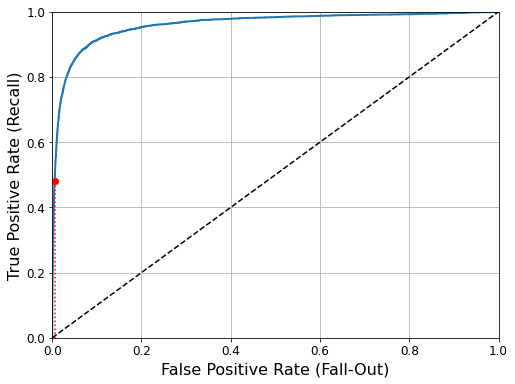

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
# save_fig("roc_curve_plot")                                    # Not shown
plt.show()

### Area Under the Curve AUC

AUC = ROC 곡선 아래 영역 
* AUC가 곺다는 사실은 클래스를 구별하는 모델의 성능이 훌륭하다는 것을 의미

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**노트**: 사이킷런 0.22 버전에서 바뀔 기본 값을 사용해 `n_estimators=100`로 지정합니다.

In [ ]:
# Random Forest 모델을 사용한 예제 
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

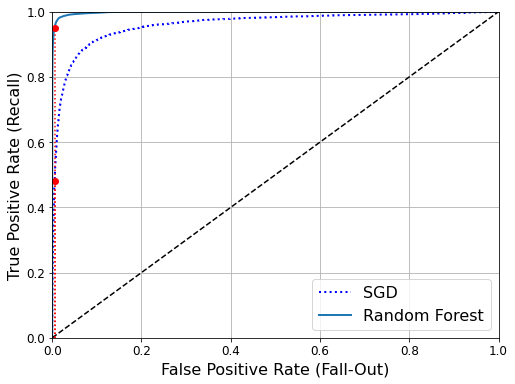

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
# save_fig("roc_curve_comparison_plot")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# 다중 분류 (SVM을 사용한 예제)

In [ ]:
# Support vector machine (SVM)을 사용한 예제
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**경고**: 사용하는 하드웨어에 따라 다음 두 셀을 실행하는데 30분 또는 그 이상 걸릴 수 있습니다.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## 에러 분석

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

사이킷런 0.22 버전부터는 `sklearn.metrics.plot_confusion_matrix()` 함수를 사용할 수 있습니다.

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
# save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
# save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
# save_fig("error_analysis_digits_plot")
plt.show()

# 다중 레이블 분류 (K-Neighbors Classifier 사용한 예제)

In [ ]:
"""
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
"""

In [ ]:
"""
knn_clf.predict([some_digit])
"""

**경고**: 다음 셀은 실행하는데 매우 오래 걸립니다(하드웨어에 따라 몇 시간이 걸릴 수 있습니다).

In [ ]:

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")


# 다중 출력 분류 (K-Neighbors Classifier 사용한 예제)

In [ ]:
"""
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
"""

In [ ]:
"""
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()
"""

In [ ]:
"""
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
# save_fig("cleaned_digit_example_plot")
"""

#연습문제

## 1. 97% 정확도의 MNIST 분류기

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 16시간 또는 그 이상 걸릴 수 있습니다.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

## 2. 데이터 증식

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 1시간 또는 그 이상 걸릴 수 있습니다.

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

간단히 데이터를 증식해서 0.5% 정확도를 높였습니다. :)

## 3. 타이타닉 데이터셋 도전

승객의 나이, 성별, 승객 등급, 승선 위치 같은 속성을 기반으로 하여 승객의 생존 여부를 예측하는 것이 목표입니다.

먼저 데이터를 로드해 보죠:

In [ ]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()   

In [ ]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [ ]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

데이터는 이미 훈련 세트와 테스트 세트로 분리되어 있습니다. 그러나 테스트 데이터는 레이블을 가지고 있지 않습니다: 훈련 데이터를 이용하여 가능한 최고의 모델을 만들고 테스트 데이터에 대한 예측을 캐글(Kaggle)에 업로드하여 최종 점수를 확인하는 것이 목표입니다.

훈련 세트에서 맨 위 몇 개의 열을 살펴 보겠습니다:

In [ ]:
train_data.head()

속성은 다음과 같은 의미를 가집니다:
* **PassengerId**: 각 승객의 고유 식별자.
* **Survived**: 타깃입니다. 0은 생존하지 못한 것이고 1은 생존을 의미합니다.
* **Pclass**: 승객 등급. 1, 2, 3등석.
* **Name**, **Sex**, **Age**: 이름 그대로 의미입니다.
* **SibSp**: 함께 탑승한 형제, 배우자의 수.
* **Parch**: 함께 탑승한 자녀, 부모의 수.
* **Ticket**: 티켓 아이디
* **Fare**: 티켓 요금 (파운드)
* **Cabin**: 객실 번호
* **Embarked**: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

`PassengerId` 열을 인덱스 열로 지정하겠습니다:

In [ ]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

누락된 데이터가 얼마나 되는지 알아보겠습니다:

In [ ]:
train_data.info()

In [ ]:
train_data[train_data["Sex"]=="female"]["Age"].median()

좋습니다. **Age**, **Cabin**, **Embarked** 속성의 일부가 null입니다(891개의 non-null 보다 작습니다). 특히 **Cabin**은 77%가 null입니다. 일단 **Cabin**은 무시하고 나머지를 활용하겠습니다. **Age**는 19%가 null이므로 이를 어떻게 처리할지 결정해야 합니다. null을 중간 나이로 바꾸는 것이 괜찮아 보입니다. 다른 열을 사용하여 나이를 예측하는 것(예를 들어, 1등석의 중간 나이는 37, 2등석은 29, 3등석은 24입니다)이 조금 현명해 보일 수 있지만 단순함을 위해 전체의 중간 나이를 사용하겠습니다.

**Name**과 **Ticket** 속성도 값을 가지고 있지만 머신러닝 모델이 사용할 수 있는 숫자로 변환하는 것이 조금 까다롭습니다. 그래서 지금은 이 두 속성을 무시하겠습니다.

통계치를 살펴 보겠습니다:

In [ ]:
train_data.describe()

* 이크, 38%만 **Survived**입니다. 😭 거의 40%에 가까우므로 정확도를 사용해 모델을 평가해도 괜찮을 것 같습니다.
* 평균 **Fare**는 32.20 파운드라 그렇게 비싸보이지는 않습니다(아마 요금을 많이 반환해 주었기 때문일 것입니다)
* 평균 **Age**는 30보다 작습니다.

타깃이 0과 1로 이루어졌는지 확인합니다:

In [ ]:
train_data["Survived"].value_counts()

범주형 특성들을 확인해 보겠습니다:

In [ ]:
train_data["Pclass"].value_counts()

In [ ]:
train_data["Sex"].value_counts()

In [ ]:
train_data["Embarked"].value_counts()

**Embarked** 특성은 승객이 탑승한 곳을 알려 줍니다: C=Cherbourg, Q=Queenstown, S=Southampton.

수치 특성을 위한 파이프라인부터 시작해서 전처리 파이프라인을 만들어 보죠:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

이제 범주형 특성을 위한 파이프라인을 만듭니다:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

마지막으로 숫자와 범주형 파이프라인을 연결합니다:

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

좋습니다! 이제 원본 데이터를 받아 머신러닝 모델에 주입할 숫자 입력 특성을 출력하는 전처리 파이프라인을 만들었습니다.

In [ ]:
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
X_train

레이블을 가져옵니다:

In [ ]:
y_train = train_data["Survived"]

이제 분류기를 훈련시킬 차례입니다. 먼저 `RandomForestClassifier`를 사용해 보겠습니다:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

모델이 잘 훈련된 것 같습니다. 이를 사용해서 테스트 세트에 대한 예측을 만듭니다:

In [ ]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

이 예측 결과를 (캐글에서 기대하는 형태인) CSV 파일로 만들어 업로드하고 평가를 받아볼 수 있습니다. 하지만 그냥 좋을거라 기대하는 것보다 교차 검증으로 모델이 얼마나 좋은지 평가하는 것이 좋습니다.

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

아주 나쁘지 않네요! 캐글에서 타이타닉 경연 대회의 [리더보드](https://www.kaggle.com/c/titanic/leaderboard)에서 상위 2% 안에 든 점수를 볼 수 있습니다. 와우! 어떤 사람들은 100%를 달성했습니다. 하지만 타이타닉의 [희생자 목록](https://www.encyclopedia-titanica.org/titanic-victims/)을 쉽게 찾을 수 있으므로 머신러닝을 사용하지 않고도 이런 정확도를 달성할 수 있습니다! 😆

`SVC`를 적용해 보겠습니다:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

좋네요! 이 모델이 훨씬 나아보입니다.

하지만 10 폴드 교차 검증에 대한 평균 정확도를 보는 대신 모델에서 얻은 10개의 점수를 1사분위, 3사분위를 명료하게 표현해주는 상자 수염 그림(box-and-whisker) 그래프를 만들어 보겠습니다(이 방식을 제안해 준 Nevin Yilmaz에게 감사합니다). `boxplot()` 함수는 이상치(플라이어(flier)라고 부릅니다)를 감지하고 수염 부분에 이를 포함시키지 않습니다. 1사분위가 $Q_1$이고 3사분위가 $Q_3$이라면 사분위수 범위는 $IQR = Q_3 - Q_1$가 됩니다(이 값이 박스의 높이가 됩니다). $Q_1 - 1.5 \times IQR$ 보다 낮거나 $Q3 + 1.5 \times IQR$ 보다 높은 점수는 이상치로 간주됩니다.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

랜덤 포레스트 분류기가 10개의 폴드 중 하나에서 매우 높은 점수를 얻었지만 넓게 퍼져 있기 때문에 전체적인 평균 점수는 낮습니다. 따라서 SVM 분류기가 일반화를 더 잘하는 것 같습니다.

이 결과를 더 향상시키려면:
* 교차 검증과 그리드 탐색을 사용하여 더 많은 모델을 비교하고 하이퍼파라미터를 튜닝하세요.
* 특성 공학을 더 시도해 보세요, 예를 들면:
  * 수치 특성을 범주형 특성으로 바꾸어 보세요: 예를 들어, 나이대가 다른 경우 다른 생존 비율을 가질 수 있습니다(아래 참조). 그러므로 나이 구간을 범주로 만들어 나이 대신 사용하는 것이 도움이 될 수 있스니다. 비슷하게 생존자의 30%가 혼자 여행하는 사람이기 때문에 이들을 위한 특별한 범주를 만드는 것이 도움이 될 수 있습니다(아래 참조).
  * **SibSp**와 **Parch**을 이 두 특성의 합으로 바꿉니다.
  * **Survived** 특성과 관련된 이름을 구별해 보세요.
  * **Cabin** 열을 사용하세요. 예를 들어 첫 글자를 범주형 속성처럼 다룰 수 있습니다.

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

## 4. 스팸 필터

먼저 데이터를 다운받습니다:

In [ ]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [ ]:
fetch_spam_data()

다음, 모든 이메일을 읽어 들입니다:

In [ ]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [ ]:
len(ham_filenames)

In [ ]:
len(spam_filenames)

파이썬의 `email` 모듈을 사용해 이메일을 파싱합니다(헤더, 인코딩 등을 처리합니다):

In [ ]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [ ]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

데이터가 어떻게 구성되어 있는지 감을 잡기 위해 햄 메일과 스팸 메일을 하나씩 보겠습니다:

In [ ]:
print(ham_emails[1].get_content().strip())

In [ ]:
print(spam_emails[6].get_content().strip())

어떤 이메일은 이미지나 첨부 파일을 가진 멀티파트(multipart)입니다(메일에 포함되어 있을수 있습니다). 어떤 파일들이 있는지 살펴 보겠습니다:

In [ ]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [ ]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
structures_counter(ham_emails).most_common()

In [ ]:
structures_counter(spam_emails).most_common()

햄 메일은 평범한 텍스트가 많고 스팸은 HTML일 경우가 많습니다. 적은 수의 햄 이메일이 PGP로 서명되어 있지만 스팸 메일에는 없습니다. 요약하면 이메일 구조는 유용한 정보입니다.

이제 이메일 헤더를 살펴보겠습니다:

In [ ]:
for header, value in spam_emails[0].items():
    print(header,":",value)

보낸사람의 이메일 주소와 같이 헤더에는 유용한 정보가 많이 있지만 여기서는 `Subject` 헤더만 다뤄 보겠습니다:

In [ ]:
spam_emails[0]["Subject"]

좋습니다. 데이터에를 더 살펴보기 전에 훈련 세트와 테스트 세트로 나누도록 하겠습니다:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

이제 전처리 함수를 작성하겠습니다. 먼저 HTML을 일반 텍스트로 변환하는 함수가 필요합니다. 이 작업에는 당연히 [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) 라이브러리를 사용하는게 좋지만 의존성을 줄이기 위해서 정규식을 사용하여 대강 만들어 보겠습니다([un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)의 위험에도 불구하고). 다음 함수는 `<head>` 섹션을 삭제하고 모든 `<a>` 태그를 HYPERLINK 문자로 바꿉니다. 그런 다음 모든 HTML 태그를 제거하고 텍스트만 남깁니다. 보기 편하게 여러개의 개행 문자를 하나로 만들고 (`&gt;`나 `&nbsp;` 같은) html 엔티티를 복원합니다:

In [ ]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

잘 작동하는지 확인해 보겠습니다. 다음은 HTML 스팸입니다:

In [ ]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

변환된 텍스트입니다:

In [ ]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")

아주 좋습니다! 이제 포맷에 상관없이 이메일을 입력으로 받아서 일반 텍스트를 출력하는 함수를 만들겠습니다:

In [ ]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [ ]:
print(email_to_text(sample_html_spam)[:100], "...")

어간 추출을 해보죠! 이 작업을 하려면 자연어 처리 툴킷([NLTK](http://www.nltk.org/))을 설치해야 합니다. 다음 명령으로 간단히 설치할 수 있습니다(먼저 virtualenv 환경을 활성화시켜야 합니다. 별도의 환경이 없다면 어드민 권한이 필요할지 모릅니다. 아니면 `--user` 옵션을 사용하세요):

`$ pip install nltk`

In [ ]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

인터넷 주소는 "URL" 문자로 바꾸겠습니다. [정규식](https://mathiasbynens.be/demo/url-regex)을 하드 코딩할 수도 있지만 [urlextract](https://github.com/lipoja/URLExtract) 라이브러리를 사용하겠습니다. 다음 명령으로 설치합니다(먼저 virtualenv 환경을 활성화시켜야 합니다. 별도의 환경이 없다면 어드민 권한이 필요할지 모릅니다. 아니면 `--user` 옵션을 사용하세요):

`$ pip install urlextract`

In [ ]:
# 코랩에서 이 노트북을 실행하려면 먼저 pip install urlextract을 실행합니다
try:
    import google.colab
    %pip install -q -U urlextract
except ImportError:
    pass # 코랩에서는 실행되지 않음

**노트:** 주피터 노트북에서는 항상 `!pip` 대신 `%pip`를 사용해야 합니다. `!pip`는 다른 환경에 라이브러리를 설치할 수 있기 때문입니다. 반면 `%pip`는 현재 실행 중인 환경에 설치됩니다.

In [ ]:
try:
    import urlextract # 루트 도메인 이름을 다운로드하기 위해 인터넷 연결이 필요할지 모릅니다
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

이들을 모두 하나의 변환기로 연결하여 이메일을 단어 카운트로 바꿀 것입니다. 파이썬의 `split()` 메서드를 사용하면 구둣점과 단어 경계를 기준으로 문장을 단어로 바꿉니다. 이 방법이 많은 언어에 통하지만 전부는 아닙니다. 예를 들어 중국어와 일본어는 일반적으로 단어 사이에 공백을 두지 않습니다. 베트남어는 음절 사이에 공백을 두기도 합니다. 여기서는 데이터셋이 (거의) 영어로 되어 있기 때문에 문제없습니다.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

이 변환기를 몇 개의 이메일에 적용해 보겠습니다:

In [ ]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

제대로 작동하는 것 같네요!

이제 단어 카운트를 벡터로 변환해야 합니다. 이를 위해서 또 다른 변환기를 만들겠습니다. 이 변환기는 (자주 나타나는 단어 순으로 정렬된) 어휘 목록을 구축하는 `fit()` 메서드와 어휘 목록을 사용해 단어를 벡터로 바꾸는 `transform()` 메서드를 가집니다. 출력은 희소 행렬이 됩니다.

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [ ]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

In [ ]:
X_few_vectors.toarray()

이 행렬은 무엇을 의미하나요? 세 번째 행의 첫 번째 열의 65는 세 번째 이메일이 어휘 목록에 없는 단어를 65개 가지고 있다는 뜻입니다. 그 다음의 0은 어휘 목록에 있는 첫 번째 단어가 한 번도 등장하지 않는다는 뜻이고 그 다음의 1은 한 번 나타난다는 뜻입니다. 이 단어들이 무엇인지 확인하려면 어휘 목록을 보면 됩니다. 첫 번째 단어는 "the"이고 두 번째 단어는 "of"입니다.

In [ ]:
vocab_transformer.vocabulary_

이제 스팸 분류기를 훈련시킬 준비를 마쳤습니다! 전체 데이터셋을 변환시켜보죠:

In [ ]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

**Note**: to be future-proof, we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

98.5%가 넘네요. 첫 번째 시도치고 나쁘지 않습니다! :) 그러나 이 데이터셋은 비교적 쉬운 문제입니다. 더 어려운 데이터셋에 적용해 보면 결과가 그리 높지 않을 것입니다. 여러개의 모델을 시도해 보고 제일 좋은 것을 골라 교차 검증으로 세밀하게 튜닝해 보세요.

하지만 전체 내용을 파악했으므로 여기서 멈추겠습니다. 테스트 세트에서 정밀도/재현율을 출력해 보겠습니다:

In [ ]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("정밀도: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("재현율: {:.2f}%".format(100 * recall_score(y_test, y_pred)))